In [8]:
import pandas as pd

file_path = 'q1_q17_dr25_sup_koi_2024.11.08_01.40.12.csv'
output_path = 'Kepler_Objects_of_interest.csv'

data = pd.read_csv(file_path, skiprows=144, on_bad_lines='skip')

data.to_csv(output_path, index=False)

print(f"새로운 파일로 저장되었습니다: {output_path}")


새로운 파일로 저장되었습니다: Kepler_Objects_of_interest.csv


In [36]:
import os
import warnings
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from sklearn.ensemble import VotingClassifier
from tensorflow.keras.layers import Input, Dense
from sklearn.metrics import f1_score, make_scorer
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split

csv_path = 'Kepler_Objects_of_interest.csv'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=0'
warnings.filterwarnings("ignore", category=UserWarning)



In [24]:
# 데이터 불러오기
data = pd.read_csv(clean_csv) #csv_path

# 모든 행 출력 설정
pd.options.display.max_rows = None

# 결측치 비율 확인
missing_data = data.isnull().mean() * 100

# 결측치가 100%인 열만 필터링하여 출력
missing_data_100 = missing_data[missing_data == 100]
print("결측치가 100%인 열:\n", missing_data_100)

# 각 클래스에 따른 데이터 분포
class_distribution = data['koi_disposition'].value_counts(normalize=True) * 100
print("\n클래스 분포:\n", class_distribution)


결측치가 100%인 열:
 Series([], dtype: float64)

클래스 분포:
 koi_disposition
FALSE POSITIVE    50.595985
CONFIRMED         28.680468
CANDIDATE         20.723547
Name: proportion, dtype: float64


In [10]:
data = pd.read_csv(csv_path)

missing_data = data.isnull().mean() * 100

data_cleaned = data.loc[:, missing_data < 100]

data_cleaned.to_csv('clean_Kepler.csv', index=False)

print("결측치 제거")
clean_csv = 'clean_Kepler.csv'


결측치 제거


In [26]:
# 데이터 불러오기
data = pd.read_csv(clean_csv)

# 데이터 전처리 (예시: 주요 특성 선택 및 타겟 분리)
selected_features = [
    'koi_period', 'koi_period_err1', 'koi_period_err2',
    'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co',
    'koi_time0', 'koi_time0_err1', 'koi_time0_err2'
]

# 실제로 데이터프레임에 존재하는 열만 선택
existing_features = [feature for feature in selected_features if feature in data.columns]

# 특성 데이터와 타겟 데이터 분리
X = data[existing_features]
y = data['koi_disposition'].astype('category').cat.codes  


In [45]:
# KNN을 사용하여 결측값 대체 (K=44 설정)
knn_imputer = KNNImputer(n_neighbors=44)
X = knn_imputer.fit_transform(X)

# 오토인코더 모델 구성
input_dim = X.shape[1]
encoding_dim = int(input_dim / 2)
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
decoder = Dense(input_dim, activation="linear")(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# EarlyStopping 설정
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# 오토인코더 모델 컴파일 및 학습
autoencoder.compile(optimizer="adam", loss="mean_squared_error")
autoencoder.fit(X, X, epochs=10, batch_size=16, shuffle=True, verbose=1, callbacks=[early_stopping])

# 오토인코더를 사용하여 결측치 대체
X_imputed = autoencoder.predict(X)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42, stratify=y)

# SMOTE 오버샘플링
smote = SMOTE(sampling_strategy='auto', random_state=42)
#smote = SMOTE(sampling_strategy={1: int(0.5 * len(y)), 2: int(0.5 * len(y))}, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Pipeline 설정
pipeline = Pipeline([
    ('imputer', KNNImputer()),  # 최적의 K 값을 찾을 KNN 임퓨터
    ('classifier', LogisticRegression(max_iter=1000))
])

# RandomizedSearchCV 파라미터 분포
param_distributions = {
    'imputer__n_neighbors': np.arange(5, 51)  
}

# F1 스코어를 기준으로 최적의 K값을 찾기 위한 설정
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    scoring=make_scorer(f1_score, average='weighted'),
    cv=5,
    random_state=42
)

# 최적의 K 찾기
random_search.fit(X_train_resampled, y_train_resampled)

# 최적의 K값과 해당 F1-score 출력
best_k = random_search.best_params_['imputer__n_neighbors']
best_f1_score = random_search.best_score_
print(f"Best K: {best_k}, F1 Score: {best_f1_score}")


Epoch 1/10


2024-11-08 23:35:36.892202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-08 23:35:36.927016: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_2.


598/598 [==============================] - 4s 6ms/step - loss: 384369459200.0000
Epoch 2/10
598/598 [==============================] - 5s 8ms/step - loss: 834462272.0000
Epoch 3/10
598/598 [==============================] - 4s 7ms/step - loss: 326280.0938
Epoch 4/10
598/598 [==============================] - 4s 7ms/step - loss: 325240.3438
Epoch 5/10
598/598 [==============================] - 4s 7ms/step - loss: 325517.4375
Epoch 6/10
598/598 [==============================] - 4s 7ms/step - loss: 325713.6562
Epoch 7/10
598/598 [==============================] - 4s 7ms/step - loss: 326156.0312
Epoch 8/10
598/598 [==============================] - 4s 7ms/step - loss: 325916.8125
Epoch 9/10
 74/299 [======>.......................] - ETA: 0s

2024-11-08 23:36:13.194011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


299/299 [==============================] - 1s 2ms/step
Best K: 44, F1 Score: 0.5774092908903146


In [46]:
# koi_disposition을 명시적인 순서로 레이블링
data['koi_disposition'] = data['koi_disposition'].astype('category')
data['koi_disposition'] = data['koi_disposition'].cat.set_categories(['FALSE POSITIVE', 'CONFIRMED', 'CANDIDATE'], ordered=True)
y = data['koi_disposition'].cat.codes

# 각 클래스의 비율 계산 및 가중치 설정
class_counts = pd.Series(y).value_counts(normalize=True)
class_weights = {i: 1 / class_counts[i] for i in class_counts.index}

print("Class weights:", class_weights)

# LightGBM 하이퍼파라미터 설정
lgbm_param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [7, 10, 15],
    'learning_rate': [0.3, 0.5, 0.6],
    'num_leaves': [63, 127, 255],
    'min_child_samples': [5, 10, 20],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# LightGBM 모델에 class_weights 적용
lgbm = LGBMClassifier(class_weight=class_weights, force_row_wise=True, verbosity=-1)

# 하이퍼파라미터 튜닝 및 모델 훈련
cv = StratifiedKFold(n_splits=10)
lgbm_search = RandomizedSearchCV(
    lgbm, lgbm_param_grid, cv=cv, scoring='balanced_accuracy',
    n_iter=10, random_state=42, n_jobs=-1, verbose=2
)
lgbm_search.fit(X_train_resampled, y_train_resampled)
best_lgbm = lgbm_search.best_estimator_

# XGBoost 하이퍼파라미터 설정
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.3, 0.5, 0.6],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# XGBoost 모델에 동일한 방식으로 적용
xgb = XGBClassifier(
    eval_metric='mlogloss', tree_method="hist", verbosity=0
)

xgb_search = RandomizedSearchCV(
    xgb, xgb_param_grid, cv=cv, scoring='balanced_accuracy',
    n_iter=10, random_state=42, n_jobs=-1, verbose=2
)
xgb_search.fit(X_train_resampled, y_train_resampled)
best_xgb = xgb_search.best_estimator_


Class weights: {0: 1.9764414135151893, 1: 3.4866934013853443, 2: 4.825428859737639}
Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END colsample_bytree=0.8, learning_rate=0.6, max_depth=7, min_child_samples=20, n_estimators=400, num_leaves=255, subsample=0.8; total time= 1.2min
[CV] END colsample_bytree=0.8, learning_rate=0.6, max_depth=7, min_child_samples=20, n_estimators=400, num_leaves=255, subsample=0.8; total time= 1.2min
[CV] END colsample_bytree=0.8, learning_rate=0.6, max_depth=7, min_child_samples=20, n_estimators=400, num_leaves=255, subsample=0.8; total time= 1.2min
[CV] END colsample_bytree=0.8, learning_rate=0.6, max_depth=7, min_child_samples=20, n_estimators=400, num_leaves=255, subsample=0.8; total time= 1.2min
[CV] END colsample_bytree=0.8, learning_rate=0.6, max_depth=7, min_child_samples=20, n_estimators=400, num_leaves=255, subsample=0.8; total time= 1.2min
[CV] END colsample_bytree=0.8, learning_rate=0.6, max_depth=7, min_child_samples=20, n_e

In [40]:
import joblib

# LightGBM 및 XGBoost 모델 저장
joblib.dump(best_lgbm, 'best_lgbm_model.joblib')
joblib.dump(best_xgb, 'best_xgb_model.joblib')

print("Save")


Save


분류 성능 평가:
               precision    recall  f1-score   support

           0       0.96      0.91      0.94       968
           1       0.63      0.64      0.64       549
           2       0.44      0.49      0.47       396

    accuracy                           0.75      1913
   macro avg       0.68      0.68      0.68      1913
weighted avg       0.76      0.75      0.75      1913



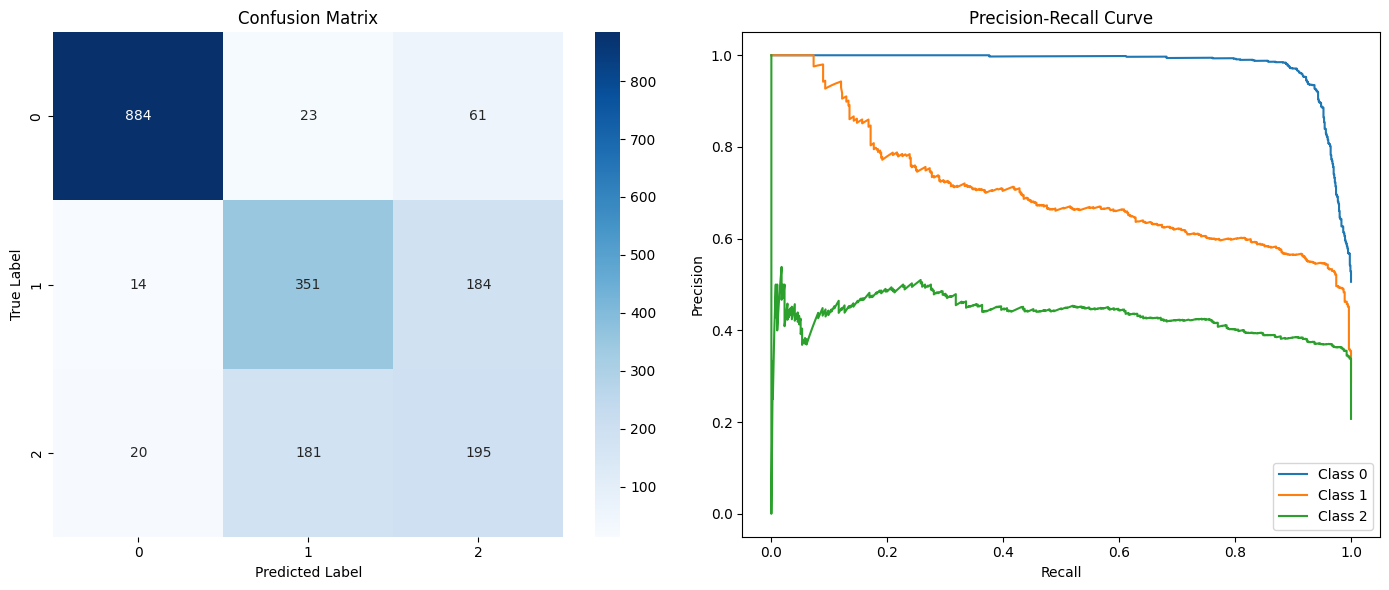

In [47]:

# 앙상블 모델 구성
ensemble_model = VotingClassifier(
    estimators=[('lgbm', best_lgbm), ('xgb', best_xgb)],
    voting='soft', weights=[1, 2]
)

# 앙상블 모델 학습
ensemble_model.fit(X_train_resampled, y_train_resampled)

# 모델 평가
from sklearn.metrics import classification_report, confusion_matrix

y_pred = ensemble_model.predict(X_test)
print("분류 성능 평가:\n", classification_report(y_test, y_pred))

from sklearn.metrics import precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt

# 혼동 행렬 생성 및 시각화
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(14, 6))

# 혼동 행렬 히트맵
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2'], yticklabels=['0', '1', '2'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Precision-Recall Curve
y_test_binary = pd.get_dummies(y_test)  # 각 클래스별로 이진화
y_pred_proba = ensemble_model.predict_proba(X_test)  # 예측 확률 계산

plt.subplot(1, 2, 2)
for i in range(3):  # 각 클래스별로 Precision-Recall Curve를 그림
    precision, recall, _ = precision_recall_curve(y_test_binary.iloc[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, label=f'Class {i}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()